In [1]:
import numpy as np 
import pandas as pd 

In [2]:
transaction_data = pd.read_excel('QVI_transaction_data.xlsx')
transaction_data.head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
5,43604,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1
6,43601,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7
7,43601,4,4196,3539,24,Grain Waves Sweet Chilli 210g,1,3.6
8,43332,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1,3.9
9,43330,7,7150,6900,52,Grain Waves Sour Cream&Chives 210G,2,7.2


In [3]:
behavior_data = pd.read_csv('QVI_purchase_behaviour.csv')
behavior_data.head(10)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
5,1007,YOUNG SINGLES/COUPLES,Budget
6,1009,NEW FAMILIES,Premium
7,1010,YOUNG SINGLES/COUPLES,Mainstream
8,1011,OLDER SINGLES/COUPLES,Mainstream
9,1012,OLDER FAMILIES,Mainstream


## Exploratory data analysis

### Examining transaction data

In [4]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [5]:
from datetime import datetime, timedelta
transaction_data['DATE'] = datetime(1899,12,30) + pd.TimedeltaIndex(transaction_data['DATE'], unit='d')

In [6]:
transaction_data['PROD_NAME'].value_counts()

Kettle Mozzarella   Basil & Pesto 175g      3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g    3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3269
Tyrrells Crisps     Ched & Chives 165g      3268
Cobs Popd Sea Salt  Chips 110g              3265
                                            ... 
RRD Pc Sea Salt     165g                    1431
Woolworths Medium   Salsa 300g              1430
NCC Sour Cream &    Garden Chives 175g      1419
French Fries Potato Chips 175g              1418
WW Crinkle Cut      Original 175g           1410
Name: PROD_NAME, Length: 114, dtype: int64

In [7]:
import re
product_words = pd.DataFrame(
    {'PROD_NAME': transaction_data['PROD_NAME'].unique()})
product_words['PROD_NAME'] = product_words['PROD_NAME'].apply(
    lambda x: re.split(r'\s+', x))
product_words = product_words.explode('PROD_NAME').reset_index(drop=True)
print(product_words)

       PROD_NAME
0        Natural
1           Chip
2         Compny
3    SeaSalt175g
4            CCs
..           ...
584         150g
585      Doritos
586        Salsa
587         Mild
588         300g

[589 rows x 1 columns]


In [8]:
mask = product_words['PROD_NAME'].str.contains('|'.join(['g', '&']), case=False)
words = product_words[~mask]
words.reset_index(drop=True)

,PROD_NAME
0,Natural
1,Chip
2,Compny
3,CCs
4,Nacho
...,...
387,Crinkle
388,Cut
389,Doritos
390,Salsa


In [9]:
target_words = words['PROD_NAME']
word_counts = {word: 0 for word in target_words}

for string in transaction_data['PROD_NAME']:
    words_in_string = string.split()
    for target_word in target_words:
        word_counts[target_word] += words_in_string.count(target_word)

In [10]:
word_table = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
word_table = word_table.sort_values(by='Count', ascending=False).reset_index(drop=True)
word_table[word_table["Word"] == 'Salsa']

,Word,Count
10,Salsa,162846


In [11]:
salsa = transaction_data['PROD_NAME'].str.contains('|'.join(['Salsa','salsa']), case=False)
transaction_data = transaction_data[~salsa]
transaction_data.reset_index(drop=True)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
246737,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
246738,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
246739,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
246740,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [12]:
transaction_data.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [13]:
transaction_data[transaction_data['PROD_QTY']==200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [14]:
transaction_data[transaction_data['LYLTY_CARD_NBR']==226000] #outlier - it is might not a retail buyer 

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [15]:
transaction_data.drop(index=transaction_data[transaction_data['LYLTY_CARD_NBR']==226000].index, inplace=True)
transaction_data.reset_index(drop=True)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
246736,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
246737,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
246738,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [16]:
date = transaction_data.groupby('DATE')['DATE'].count()
date

DATE
2018-07-01    663
2018-07-02    650
2018-07-03    674
2018-07-04    669
2018-07-05    660
             ... 
2019-06-26    657
2019-06-27    669
2019-06-28    673
2019-06-29    703
2019-06-30    704
Name: DATE, Length: 364, dtype: int64

In [17]:
index = pd.date_range(start = "2018-07-01", end = "2019-06-30", freq = "D")
index

DatetimeIndex(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04',
               '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08',
               '2018-07-09', '2018-07-10',
               ...
               '2019-06-21', '2019-06-22', '2019-06-23', '2019-06-24',
               '2019-06-25', '2019-06-26', '2019-06-27', '2019-06-28',
               '2019-06-29', '2019-06-30'],
              dtype='datetime64[ns]', length=365, freq='D')

In [18]:
transaction = {j: 0 for j in index}
for i in index :
    if i in list(date.index) :
        transaction[i] = date[i] 
    else :
        transaction[i] = 0

number_transaction = pd.DataFrame(transaction.items(), columns=['Date', 'Transactions'])

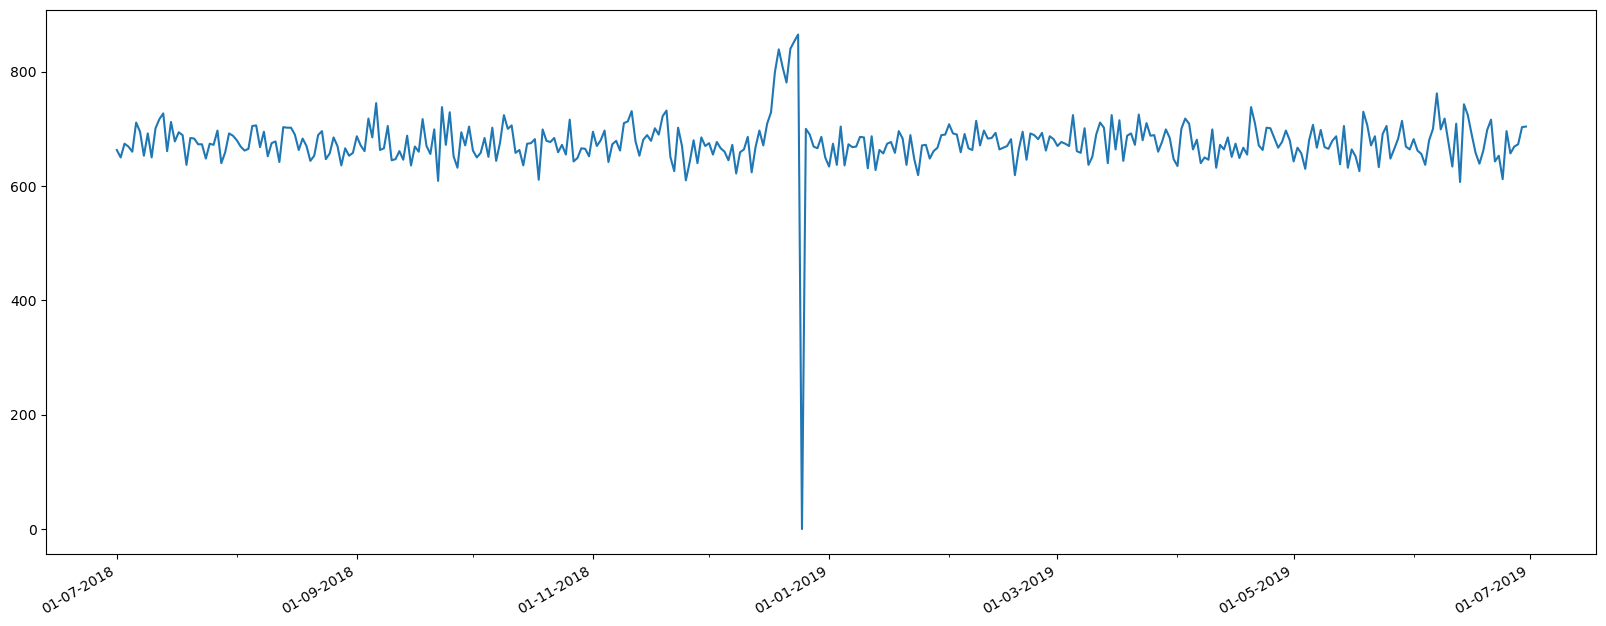

In [19]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(number_transaction.Date, number_transaction.Transactions)
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

plt.show() #There's a missing date in data 

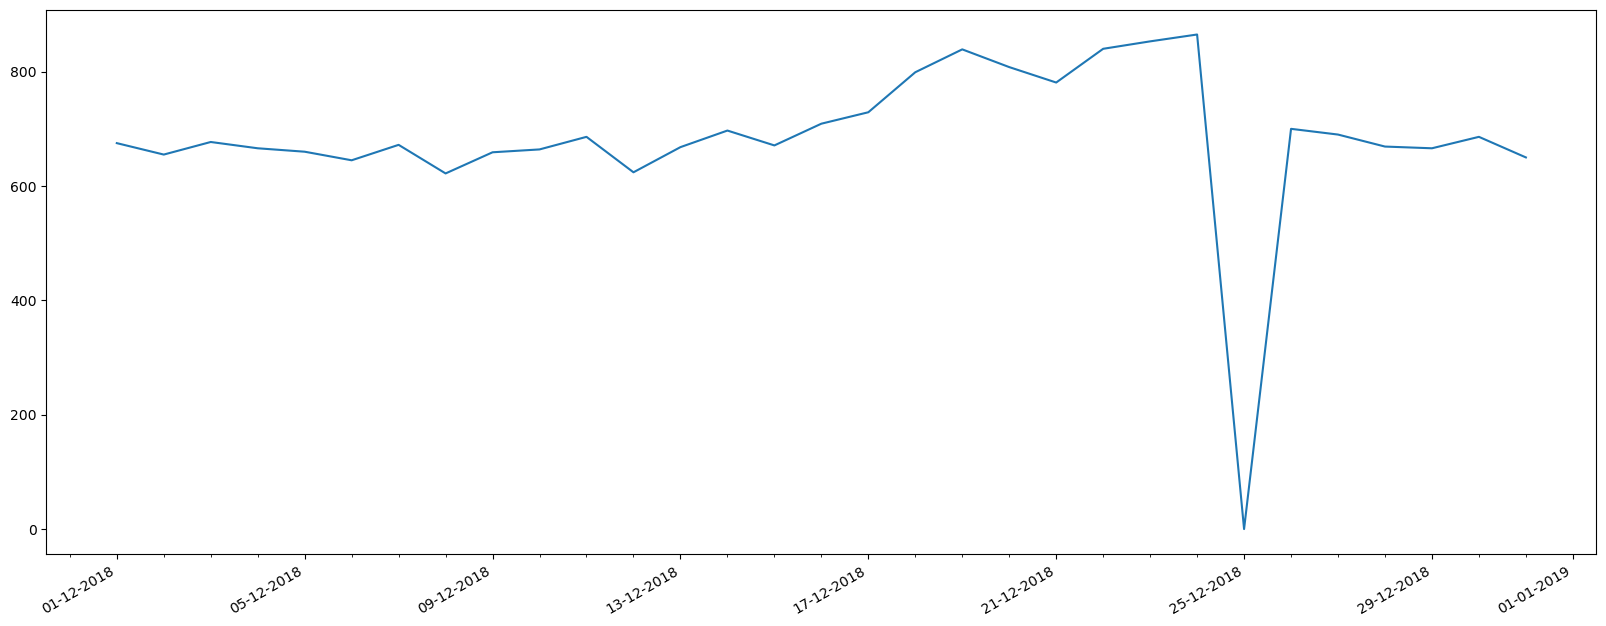

In [20]:
dec_date = number_transaction[number_transaction['Date'].dt.month == 12]
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(dec_date.Date, dec_date.Transactions)
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

plt.show()

In [21]:
number_transaction[number_transaction['Date'].dt.month == 12] #no sales on Christmas Day due to shop closed 

,Date,Transactions
153,2018-12-01,675
154,2018-12-02,655
155,2018-12-03,677
156,2018-12-04,666
157,2018-12-05,660
158,2018-12-06,645
159,2018-12-07,672
160,2018-12-08,622
161,2018-12-09,659
162,2018-12-10,664


In [22]:
# Extract package size from product name 
product_size = []
for name in transaction_data['PROD_NAME'] :
    product_size.append(re.findall(r'(\d+)', name)) 

transaction_data['PROD_SIZE'] = np.array(product_size).astype(int)

In [23]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 264835
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            246740 non-null  datetime64[ns]
 1   STORE_NBR       246740 non-null  int64         
 2   LYLTY_CARD_NBR  246740 non-null  int64         
 3   TXN_ID          246740 non-null  int64         
 4   PROD_NBR        246740 non-null  int64         
 5   PROD_NAME       246740 non-null  object        
 6   PROD_QTY        246740 non-null  int64         
 7   TOT_SALES       246740 non-null  float64       
 8   PROD_SIZE       246740 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 18.8+ MB


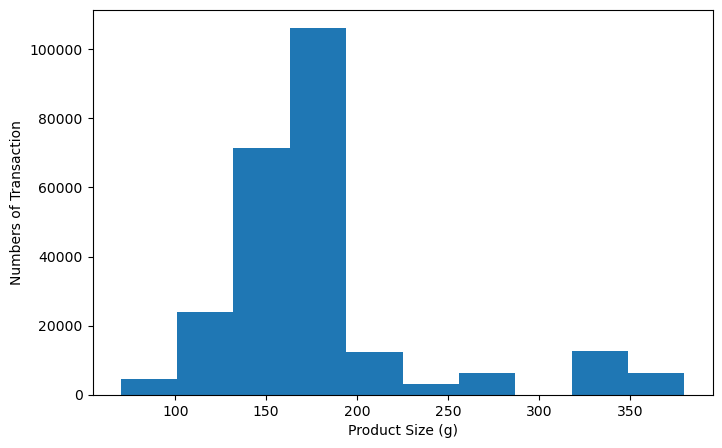

In [24]:
ax, fig = plt.subplots(figsize=[8,5])
ax = plt.hist(transaction_data['PROD_SIZE'])
plt.xlabel('Product Size (g)')
plt.ylabel('Numbers of Transaction')
plt.show()

In [25]:
# Extract brand name from product name 
brand = []
for name in transaction_data['PROD_NAME']:
    brand.append(name.split(' ', 1)[0])

brand = pd.DataFrame(brand, columns=['Brand'])

In [26]:
brand['Brand'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [27]:
brand['Brand'] = brand['Brand'].str.replace('Red','RRD')
brand['Brand'] = brand['Brand'].str.replace('WW','Woolworths')
brand['Brand'] = brand['Brand'].str.replace(r'\bDorito\b','Doritos')
brand['Brand'] = brand['Brand'].str.replace('Infzns','Infuzions')
brand['Brand'] = brand['Brand'].str.replace('Snbts','Sunbites')
brand['Brand'] = brand['Brand'].str.replace('Natural','NCC')
brand['Brand'] = brand['Brand'].str.replace('GrnWves','Grain')
brand['Brand'] = brand['Brand'].str.replace(r'\bSmith\b','Smiths')

/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31764/491633575.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  brand['Brand'] = brand['Brand'].str.replace(r'\bDorito\b','Doritos')
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31764/491633575.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  brand['Brand'] = brand['Brand'].str.replace(r'\bSmith\b','Smiths')


In [28]:
brand['Brand'].unique()

array(['NCC', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos', 'Twisties',
       'Woolworths', 'Thins', 'Burger', 'Cheezels', 'Infuzions', 'RRD',
       'Pringles', 'Tyrrells', 'Cobs', 'French', 'Tostitos', 'Cheetos',
       'Sunbites'], dtype=object)

In [29]:
transaction_data['BRAND'] = np.array(brand['Brand'])

### Examining customer behavior data

In [30]:
behavior_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [31]:
behavior_data['LIFESTAGE'].value_counts()

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

In [32]:
behavior_data['PREMIUM_CUSTOMER'].value_counts()

Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64

### Merge two dataset

In [33]:
data = pd.merge(transaction_data, behavior_data, on='LYLTY_CARD_NBR')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 246739
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              246740 non-null  datetime64[ns]
 1   STORE_NBR         246740 non-null  int64         
 2   LYLTY_CARD_NBR    246740 non-null  int64         
 3   TXN_ID            246740 non-null  int64         
 4   PROD_NBR          246740 non-null  int64         
 5   PROD_NAME         246740 non-null  object        
 6   PROD_QTY          246740 non-null  int64         
 7   TOT_SALES         246740 non-null  float64       
 8   PROD_SIZE         246740 non-null  int64         
 9   BRAND             246740 non-null  object        
 10  LIFESTAGE         246740 non-null  object        
 11  PREMIUM_CUSTOMER  246740 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 24.5+ MB


In [34]:
data.to_csv("data.csv", index=False)

## Data Analysis on customer segments

In [35]:
sales_stage = data.pivot_table(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='TOT_SALES',aggfunc='sum')
sales_stage

PREMIUM_CUSTOMER,Budget,Mainstream,Premium
LIFESTAGE,,,
MIDAGE SINGLES/COUPLES,33345.70,84734.25,54443.85
NEW FAMILIES,20607.45,15979.70,10760.80
OLDER FAMILIES,156863.75,96413.55,75242.60
OLDER SINGLES/COUPLES,127833.60,124648.50,123537.55
RETIREES,105916.30,145168.95,91296.65
YOUNG FAMILIES,129717.95,86338.25,78571.70
YOUNG SINGLES/COUPLES,57122.10,147582.20,39052.30


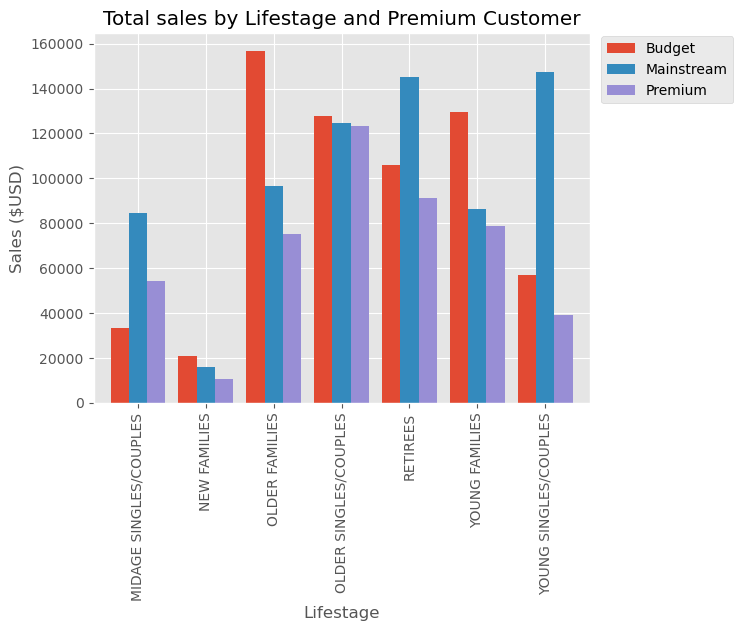

In [36]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")

sales_stage.plot.bar(rot=0, width=0.8)
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.xticks(rotation='vertical')
plt.title("Total sales by Lifestage and Premium Customer")
plt.xlabel("Lifestage")
plt.ylabel("Sales ($USD)")
plt.show()

Sales are coming mainly from Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees.

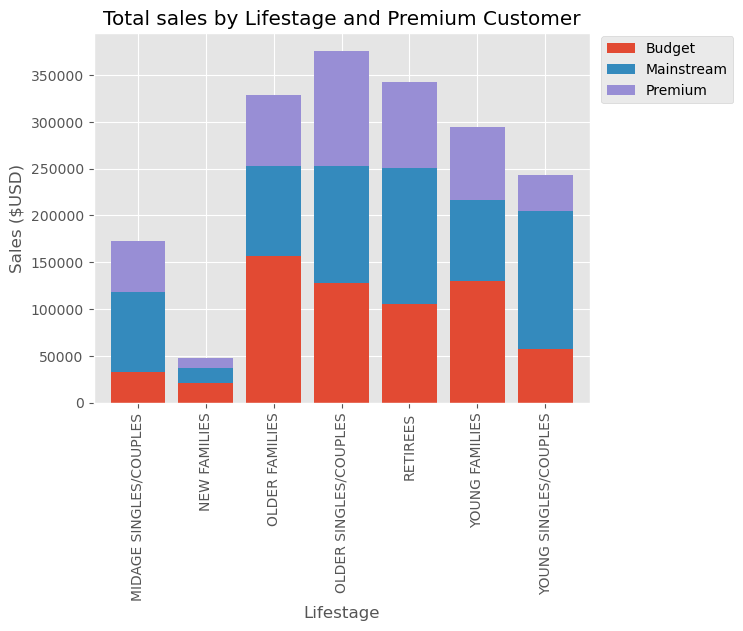

In [37]:
fig, ax = plt.subplots()
sales_stage.plot.bar(rot=0, width=0.8, ax=ax, stacked=True)
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.xticks(rotation='vertical')
plt.title("Total sales by Lifestage and Premium Customer")
plt.xlabel("Lifestage")
plt.ylabel("Sales ($USD)")
plt.show()

In [38]:
customer_stage = data.pivot_table(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='LYLTY_CARD_NBR',aggfunc=lambda x: len(x.unique()))
customer_stage

PREMIUM_CUSTOMER,Budget,Mainstream,Premium
LIFESTAGE,,,
MIDAGE SINGLES/COUPLES,1474,3298,2369
NEW FAMILIES,1087,830,575
OLDER FAMILIES,4611,2788,2231
OLDER SINGLES/COUPLES,4849,4858,4682
RETIREES,4385,6358,3812
YOUNG FAMILIES,3953,2685,2398
YOUNG SINGLES/COUPLES,3647,7917,2480


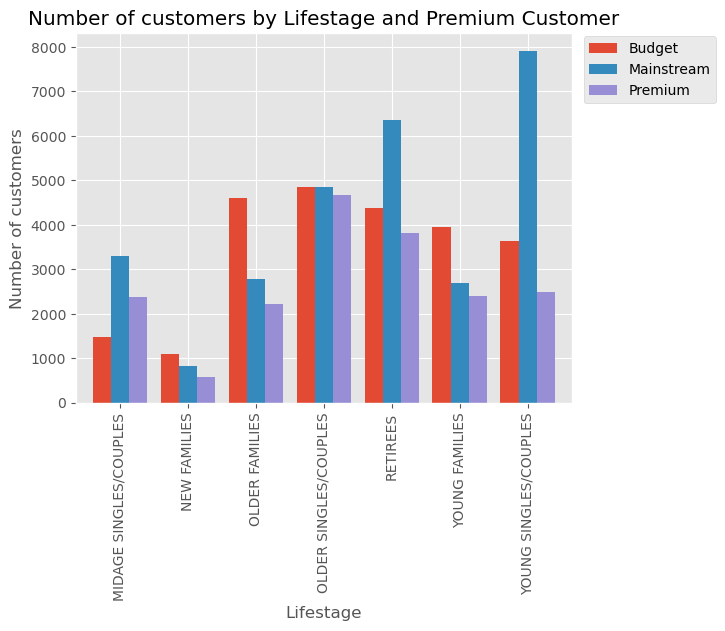

In [39]:
customer_stage.plot.bar(rot=0, width=0.8)
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.xticks(rotation='vertical')
plt.title("Number of customers by Lifestage and Premium Customer")
plt.xlabel("Lifestage")
plt.ylabel("Number of customers")
plt.show()

There are more Mainstream - young singles/couples and Mainstream - retirees who buy chips. This con- tributes to there being more sales to these customer segments but this is not a major driver for the Budget - Older families segment.

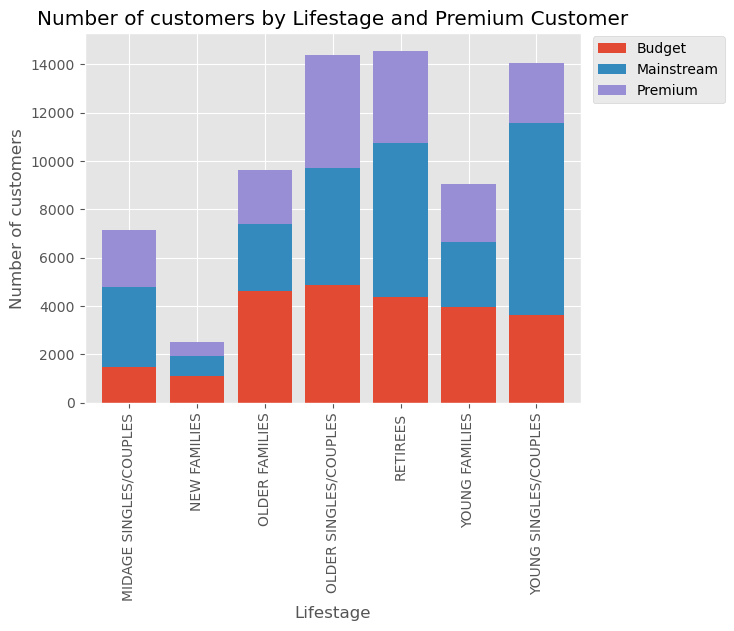

In [40]:
customer_stage.plot.bar(rot=0, width=0.8, stacked=True)
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.xticks(rotation='vertical')
plt.title("Number of customers by Lifestage and Premium Customer")
plt.xlabel("Lifestage")
plt.ylabel("Number of customers")
plt.show()

In [41]:
proportion = customer_stage/data['LYLTY_CARD_NBR'].nunique()

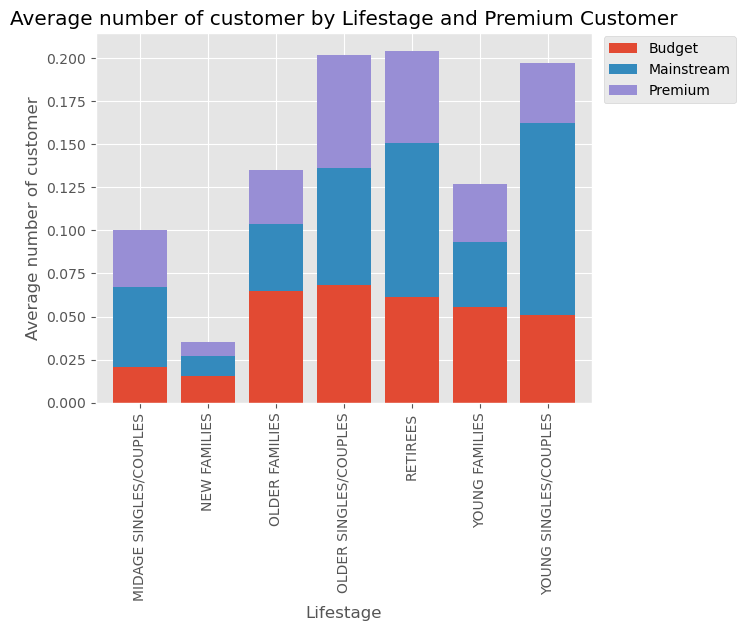

In [42]:
proportion.plot.bar(rot=0, width=0.8, stacked=True)
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.xticks(rotation='vertical')
plt.title("Average number of customer by Lifestage and Premium Customer")
plt.xlabel("Lifestage")
plt.ylabel("Average number of customer")
plt.show()

In [43]:
unit_stage = data.pivot_table(index='PREMIUM_CUSTOMER', columns='LIFESTAGE', values='PROD_QTY',aggfunc='mean')
unit_stage

LIFESTAGE,MIDAGE SINGLES/COUPLES,NEW FAMILIES,OLDER FAMILIES,OLDER SINGLES/COUPLES,RETIREES,YOUNG FAMILIES,YOUNG SINGLES/COUPLES
PREMIUM_CUSTOMER,,,,,,,
Budget,1.893626,1.855878,1.945384,1.914920,1.893286,1.941226,1.808002
Mainstream,1.911942,1.858124,1.948795,1.911201,1.886680,1.941408,1.853510
Premium,1.891750,1.860887,1.945496,1.913949,1.901438,1.938149,1.807075


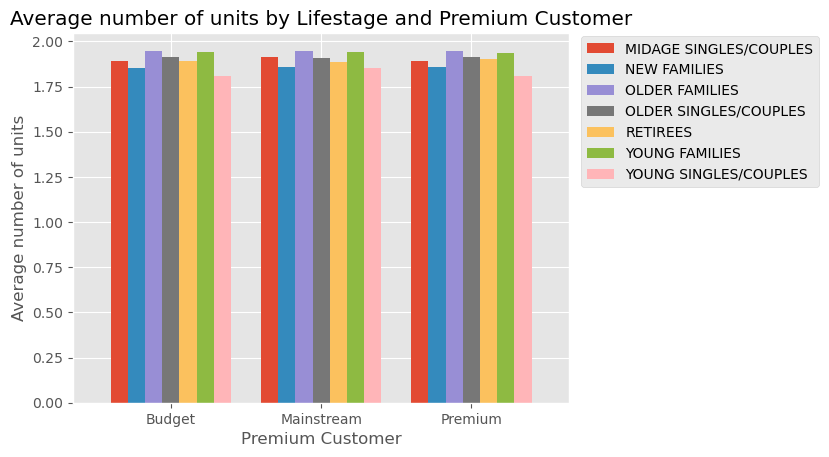

In [44]:
fig, ax = plt.subplots()
unit_stage.plot.bar(rot=0, width=0.8, ax= ax)
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.title("Average number of units by Lifestage and Premium Customer")
plt.xlabel("Premium Customer")
plt.ylabel("Average number of units")
plt.show()

In [45]:
data['PRICE_UNIT'] = data['TOT_SALES'] / data['PROD_QTY']
price_unit = data.pivot_table(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='PRICE_UNIT',aggfunc='mean')
price_unit

PREMIUM_CUSTOMER,Budget,Mainstream,Premium
LIFESTAGE,,,
MIDAGE SINGLES/COUPLES,3.743328,3.994241,3.770698
NEW FAMILIES,3.917688,3.916133,3.872110
OLDER FAMILIES,3.745340,3.737077,3.717000
OLDER SINGLES/COUPLES,3.882096,3.814665,3.893182
RETIREES,3.924404,3.844294,3.920942
YOUNG FAMILIES,3.760737,3.724533,3.762150
YOUNG SINGLES/COUPLES,3.657366,4.065642,3.665414


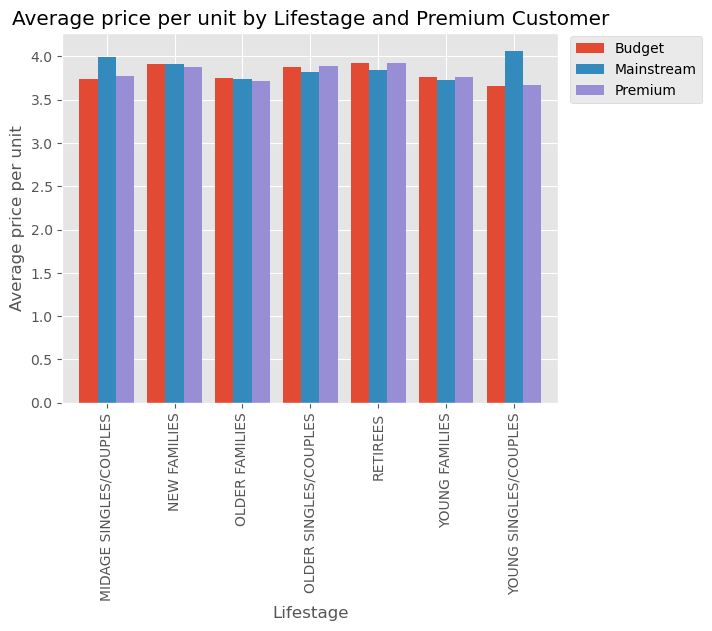

In [46]:
fig, ax = plt.subplots()
price_unit.plot.bar(rot=0, width=0.8, ax=ax)
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.xticks(rotation='vertical')
plt.title("Average price per unit by Lifestage and Premium Customer")
plt.xlabel("Lifestage")
plt.ylabel("Average price per unit")
plt.show()

In [47]:
sum_unit = data.pivot_table(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='PROD_QTY',aggfunc='sum')
avg_unit = sum_unit/customer_stage
avg_unit

PREMIUM_CUSTOMER,Budget,Mainstream,Premium
LIFESTAGE,,,
MIDAGE SINGLES/COUPLES,6.026459,6.432080,6.078514
NEW FAMILIES,4.821527,4.891566,4.815652
OLDER FAMILIES,9.076773,9.255380,9.071717
OLDER SINGLES/COUPLES,6.781398,6.712021,6.769543
RETIREES,6.141847,5.925920,6.103358
YOUNG FAMILIES,8.722995,8.638361,8.716013
YOUNG SINGLES/COUPLES,4.250069,4.575597,4.264113


In [48]:
avg_unit.loc['YOUNG FAMILIES'].mean()

8.692456601423949

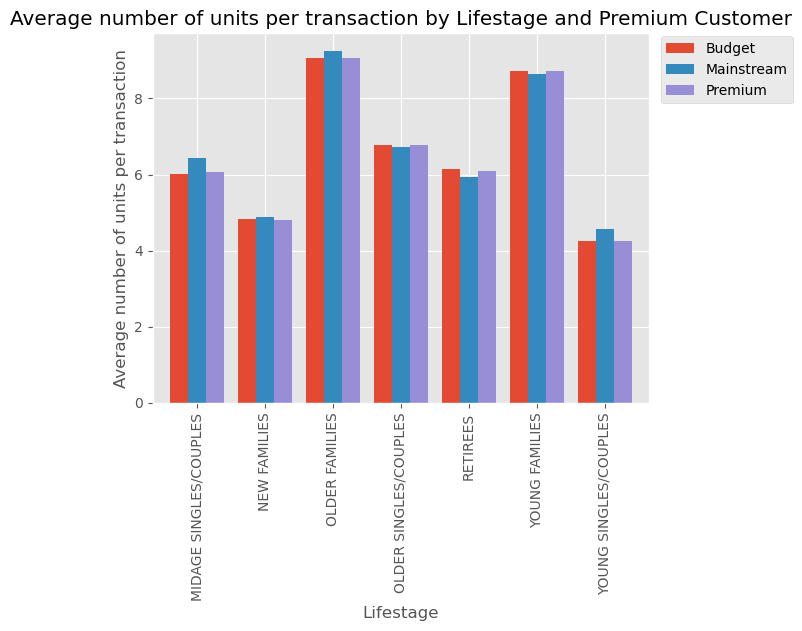

In [49]:
fig, ax = plt.subplots()
avg_unit.plot.bar(rot=0, width=0.8, ax=ax)
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.xticks(rotation='vertical')
plt.title("Average number of units per transaction by Lifestage and Premium Customer")
plt.xlabel("Lifestage")
plt.ylabel("Average number of units per transaction")
plt.show()

In [50]:
from scipy import stats 

x = data.loc[(data['PREMIUM_CUSTOMER'] == 'Mainstream') & (data['LIFESTAGE']=='MIDAGE SINGLES/COUPLES')  | (data['LIFESTAGE']=='YOUNG SINGLES/COUPLES'),'PRICE_UNIT']
y = data.loc[(data['PREMIUM_CUSTOMER'] == 'Budget') | (data['PREMIUM_CUSTOMER'] == 'Premium') & (data['LIFESTAGE']=='MIDAGE SINGLES/COUPLES')  | (data['LIFESTAGE']=='YOUNG SINGLES/COUPLES'),'PRICE_UNIT']
t_stat, p_val = stats.ttest_ind(x, y)  
t_stat, p_val

(13.8741230882148, 9.62042724564752e-44)

In [51]:
mainstream_young = data[(data['LIFESTAGE']=='YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream')]
mainstream_young.groupby('BRAND')['BRAND'].count().sort_values(ascending=False)

BRAND
Kettle        3844
Doritos       2379
Pringles      2315
Smiths        1921
Infuzions     1250
Thins         1166
Twisties       900
Tostitos       890
RRD            875
Cobs           864
Grain          646
Tyrrells       619
Woolworths     479
NCC            394
Cheezels       346
CCs            222
Cheetos        166
Sunbites       128
French          78
Burger          62
Name: BRAND, dtype: int64

In [52]:
brand_fav = data.pivot_table(index=['PREMIUM_CUSTOMER','LIFESTAGE'], columns='BRAND', values='LYLTY_CARD_NBR',aggfunc='count')
brand_fav

BRAND                                    Burger  CCs  Cheetos  Cheezels  Cobs  \
PREMIUM_CUSTOMER LIFESTAGE                                                      
Budget           MIDAGE SINGLES/COUPLES      43  112       61        74   180   
                 NEW FAMILIES                18   44       26        46   124   
                 OLDER FAMILIES             159  451      281       427   760   
                 OLDER SINGLES/COUPLES      110  256      191       323   706   
                 RETIREES                    66  200      156       264   602   
                 YOUNG FAMILIES             124  398      218       335   612   
                 YOUNG SINGLES/COUPLES       59  218      118       157   290   
Mainstream       MIDAGE SINGLES/COUPLES      48  159      115       221   495   
                 NEW FAMILIES                14   26       18        43    96   
                 OLDER FAMILIES             123  273      195       214   505   
                 OLDER SINGLES/COUPLES       93  336      198       301   699   
                 RETIREES                   122  355      236       382   776   
                 YOUNG FAMILIES              86  260      183       228   454   
                 YOUNG SINGLES/COUPLES       62  222      166       346   864   
Premium          MIDAGE SINGLES/COUPLES      61  162       89       148   286   
                 NEW FAMILIES                 8   23       18        40    68   
                 OLDER FAMILIES              71  217      139       172   359   
                 OLDER SINGLES/COUPLES       89  259      191       342   631   
                 RETIREES                    68  186       99       221   506   
                 YOUNG FAMILIES              83  240      149       208   438   
                 YOUNG SINGLES/COUPLES       57  154       80       111   242   

BRAND                                    Doritos  French  Grain  Infuzions  \
PREMIUM_CUSTOMER LIFESTAGE                                                   
Budget           MIDAGE SINGLES/COUPLES      479      26    132        281   
                 NEW FAMILIES                315      14     82        180   
                 OLDER FAMILIES             2032     142    671       1185   
                 OLDER SINGLES/COUPLES      1751      87    542       1043   
                 RETIREES                   1592      76    421        779   
                 YOUNG FAMILIES             1767     123    565        998   
                 YOUNG SINGLES/COUPLES       782      71    243        456   
Mainstream       MIDAGE SINGLES/COUPLES     1210      43    355        679   
                 NEW FAMILIES                257      15     70        126   
                 OLDER FAMILIES             1263      82    444        717   
                 OLDER SINGLES/COUPLES      1791     104    524        959   
                 RETIREES                   2089      96    667       1182   
                 YOUNG FAMILIES             1125      89    331        637   
                 YOUNG SINGLES/COUPLES      2379      78    646       1250   
Premium          MIDAGE SINGLES/COUPLES      734      48    245        443   
                 NEW FAMILIES                154       3     61         87   
                 OLDER FAMILIES              923      59    314        594   
                 OLDER SINGLES/COUPLES      1784      95    537        960   
                 RETIREES                   1306      56    378        758   
                 YOUNG FAMILIES             1002      66    325        580   
                 YOUNG SINGLES/COUPLES       489      45    187        307   

BRAND                                    Kettle  NCC  Pringles   RRD  Smiths  \
PREMIUM_CUSTOMER LIFESTAGE                                                     
Budget           MIDAGE SINGLES/COUPLES     713  170       449   334     591   
                 NEW FAMILIES               510   72       309   134     328   
                 OLDE

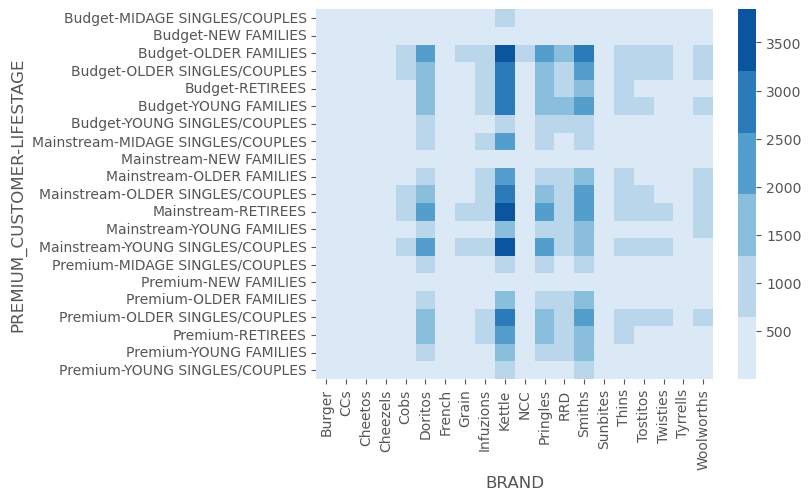

In [53]:
import seaborn as sns
colormap = sns.color_palette("Blues") 
sns.heatmap(brand_fav, cmap=colormap)
plt.show()

In [54]:
segment1 = data[(data['PREMIUM_CUSTOMER']=='Mainstream') & (data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]
others = data[~(data['PREMIUM_CUSTOMER']=='Mainstream') & ~(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]
qty_seg_brand = segment1.groupby('BRAND')['PROD_QTY'].sum()
qty_other_brand = others.groupby('BRAND')['PROD_QTY'].sum()

In [55]:
brand_proportions = pd.merge(qty_seg_brand, qty_other_brand, on='BRAND', suffixes =['_Mainstream','_Other'])
brand_proportions

,PROD_QTY_Mainstream,PROD_QTY_Other
BRAND,,
Burger,106,1723
CCs,405,4861
Cheetos,291,3099
Cheezels,651,4982
Cobs,1617,10133
Doritos,4447,26663
French,143,1504
Grain,1185,8188
Infuzions,2343,15130


In [56]:
brand_proportions['PROD_QTY_Mainstream'] = brand_proportions['PROD_QTY_Mainstream']/segment1['PROD_QTY'].sum()
brand_proportions['PROD_QTY_Other'] = brand_proportions['PROD_QTY_Other']/others['PROD_QTY'].sum()
brand_proportions['affinityToBrand'] = brand_proportions['PROD_QTY_Mainstream']/brand_proportions['PROD_QTY_Other']

In [57]:
brand_proportions.sort_values(by='affinityToBrand', ascending=False)

,PROD_QTY_Mainstream,PROD_QTY_Other,affinityToBrand
BRAND,,,
Tyrrells,0.031553,0.025715,1.227025
Twisties,0.046184,0.037933,1.217506
Doritos,0.122761,0.101171,1.213397
Kettle,0.197985,0.166560,1.188667
Tostitos,0.045411,0.038350,1.184100
Pringles,0.119420,0.101110,1.181090
Cobs,0.044638,0.038449,1.160959
Infuzions,0.064679,0.057410,1.126622
Thins,0.060373,0.057159,1.056217


In [58]:
size_fav = data.pivot_table(index=['PREMIUM_CUSTOMER','LIFESTAGE'], columns='PROD_SIZE', values='LYLTY_CARD_NBR',aggfunc='count')
size_fav

PROD_SIZE                                70   90    110  125   134  135   150  \
PREMIUM_CUSTOMER LIFESTAGE                                                      
Budget           MIDAGE SINGLES/COUPLES   27   70   434   27   449   51   771   
                 NEW FAMILIES             13   30   291   20   309   38   440   
                 OLDER FAMILIES          142  305  1803  152  1996  268  3588   
                 OLDER SINGLES/COUPLES   120  191  1629  100  1843  243  2811   
                 RETIREES                 63  160  1318   63  1517  191  2319   
                 YOUNG FAMILIES          122  254  1488  108  1674  212  2862   
                 YOUNG SINGLES/COUPLES    69  136   677   72   832   92  1390   
Mainstream       MIDAGE SINGLES/COUPLES   50   69  1124   35  1159  163  1777   
                 NEW FAMILIES              8   15   214   15   224   39   374   
                 OLDER FAMILIES           91  169  1131   81  1234  137  2189   
                 OLDER SINGLES/COUPLES   101  222  1557  111  1720  279  2773   
                 RETIREES                129  243  1829  121  2103  263  3290   
                 YOUNG FAMILIES           81  196  1010   83  1148  145  2004   
                 YOUNG SINGLES/COUPLES    63  128  2051   59  2315  290  3080   
Premium          MIDAGE SINGLES/COUPLES   64  110   665   46   781   95  1207   
                 NEW FAMILIES              7   16   148   18   165   14   233   
                 OLDER FAMILIES           78  148   875   64  1014  129  1673   
                 OLDER SINGLES/COUPLES    87  171  1504   95  1744  218  2768   
                 RETIREES                 71  132  1193   72  1331  176  1943   
                 YOUNG FAMILIES           71  146   947   66  1007  144  1778   
                 YOUNG SINGLES/COUPLES    50   97   499   46   537   70   933   

PROD_SIZE                                160   165   170   175  180  190  200  \
PREMIUM_CUSTOMER LIFESTAGE                                                      
Budget           MIDAGE SINGLES/COUPLES   73   316   370  1277   26   52  102   
                 NEW FAMILIES             29   154   239   777   14   25   41   
                 OLDER FAMILIES          306  1358  1786  5808  166  312  448   
                 OLDER SINGLES/COUPLES   188   983  1321  4625  104  183  277   
                 RETIREES                150   843  1169  3847   62  151  212   
                 YOUNG FAMILIES          228  1166  1484  4921  125  242  369   
                 YOUNG SINGLES/COUPLES   148   602   724  2338   45  132  215   
Mainstream       MIDAGE SINGLES/COUPLES  101   641   882  2975   48  116  132   
                 NEW FAMILIES             23   126   169   589    9   23   30   
                 OLDER FAMILIES          169   913  1073  3588   99  201  295   
                 OLDER SINGLES/COUPLES   212  1061  1433  4525  100  226  330   
                 RETIREES                221  1182  1636  5295  127  218  342   
                 YOUNG FAMILIES          162   828  1016  3174   68  177  246   
                 YOUNG SINGLES/COUPLES   128  1102  1575  4997   70  148  179   
Premium          MIDAGE SINGLES/COUPLES  116   491   583  2082   45   98  154   
                 NEW FAMILIES             15    89   113   376    7   23   35   
                 OLDER FAMILIES          163   738   825  2816   74  139  250   
                 OLDER SINGLES/COUPLES   183   918  1324  4458   88  190  270   
                 RETIREES                112   700   959  3306   63   92  177   
                 YOUNG FAMILIES          131   713   850  2998   80  158  225   
                 YOUNG SINGLES/COUPLES   112   373   452  1618   48   89  144   

PROD_SIZE                                210  220  250  270   330  380  
PREMIUM_CUSTOMER LIFESTAGE                                              
Budget           MIDAGE SINGLES/COUPLES  106   43   47  129   207  114  
                 NEW FAMILIES             68   18   3

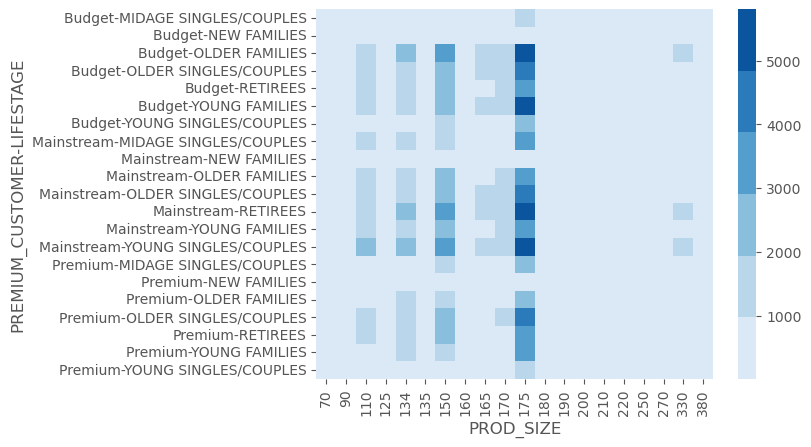

In [59]:
sns.heatmap(size_fav, cmap=colormap)
plt.show()

In [60]:
size_seg_brand = segment1.groupby('PROD_SIZE')['PROD_QTY'].sum()
size_other_brand = others.groupby('PROD_SIZE')['PROD_QTY'].sum()
size_proportions = pd.merge(size_seg_brand, size_other_brand, on='PROD_SIZE', suffixes =['_Mainstream','_Other'])
size_proportions

,PROD_QTY_Mainstream,PROD_QTY_Other
PROD_SIZE,,
70,110,1656
90,230,3324
110,3850,23607
125,109,1575
134,4326,26647
135,535,3408
150,5709,42976
160,232,3221
165,2016,16231


In [61]:
size_proportions['PROD_QTY_Mainstream'] = size_proportions['PROD_QTY_Mainstream']/segment1['PROD_QTY'].sum()
size_proportions['PROD_QTY_Other'] = size_proportions['PROD_QTY_Other']/others['PROD_QTY'].sum()
size_proportions['affinityToSize'] = size_proportions['PROD_QTY_Mainstream']/size_proportions['PROD_QTY_Other']
size_proportions.sort_values(by='affinityToSize', ascending=False)

,PROD_QTY_Mainstream,PROD_QTY_Other,affinityToSize
PROD_SIZE,,,
270,0.031829,0.025070,1.269608
380,0.032160,0.025711,1.250827
330,0.061284,0.050974,1.202243
110,0.106280,0.089575,1.186492
134,0.119420,0.101110,1.181090
210,0.029124,0.024891,1.170020
135,0.014769,0.012931,1.142086
250,0.014355,0.012863,1.115959
170,0.080773,0.080347,1.005300
